# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#!pip install -U sklearn
!pip install -U scikit-learn # без обновления энкодеры вываливаются в ошибку при определенных комбинациях параметров
!pip install lightgbm


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os, warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
#import lightgbm
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV #, StratifiedKFold, KFold,
from IPython.display import display, Markdown, HTML
from sklearn.metrics import make_scorer#, mean_squared_error as MSE
from sklearn.metrics import root_mean_squared_error as MSE


In [3]:
RS = 1
VERBOSE = 3
CV = 3

In [4]:
try:
    data=pd.read_csv("/datasets/autos.csv", parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [5]:
pd.set_option('display.max_columns', None)
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [6]:
data = data.fillna('is_na')

In [7]:
data.duplicated().sum()

4

In [8]:
data = data.drop_duplicates().reset_index(drop=True)

In [9]:
print(f'пропусков: {data.isna().sum().sum()}\n')
data.info()
data.describe()#datetime_is_numeric=True)

пропусков: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365,354365.0,354365.000000,354365
mean,2016-03-21 12:58:09.520460544,4416.679830,2004.234481,110.093816,128211.363989,5.714650,2016-03-20 19:12:06.583042560,0.0,50508.503800,2016-03-29 23:51:06.766184960
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:52
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.176349,90.228466,189.851330,37905.083858,3.726432,NaN,0.0,25783.100078,NaN


In [10]:
#NumberOfPictures
for i in data.columns[data.nunique() == 1]:
    print(f"Полностью бесполезный столбец '{i}' удаляется")
    data = data.drop(i, axis=1)
data

Полностью бесполезный столбец 'NumberOfPictures' удаляется


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,is_na,1993,manual,0,golf,150000,0,petrol,volkswagen,is_na,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,is_na,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,is_na,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-03-21 09:50:58,0,is_na,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,is_na,2005,is_na,0,is_na,20000,1,is_na,sonstige_autos,is_na,2016-03-14,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,87439,2016-04-07 07:15:26


In [11]:
#data.hist(figsize=(20,10), bins=100); #v1

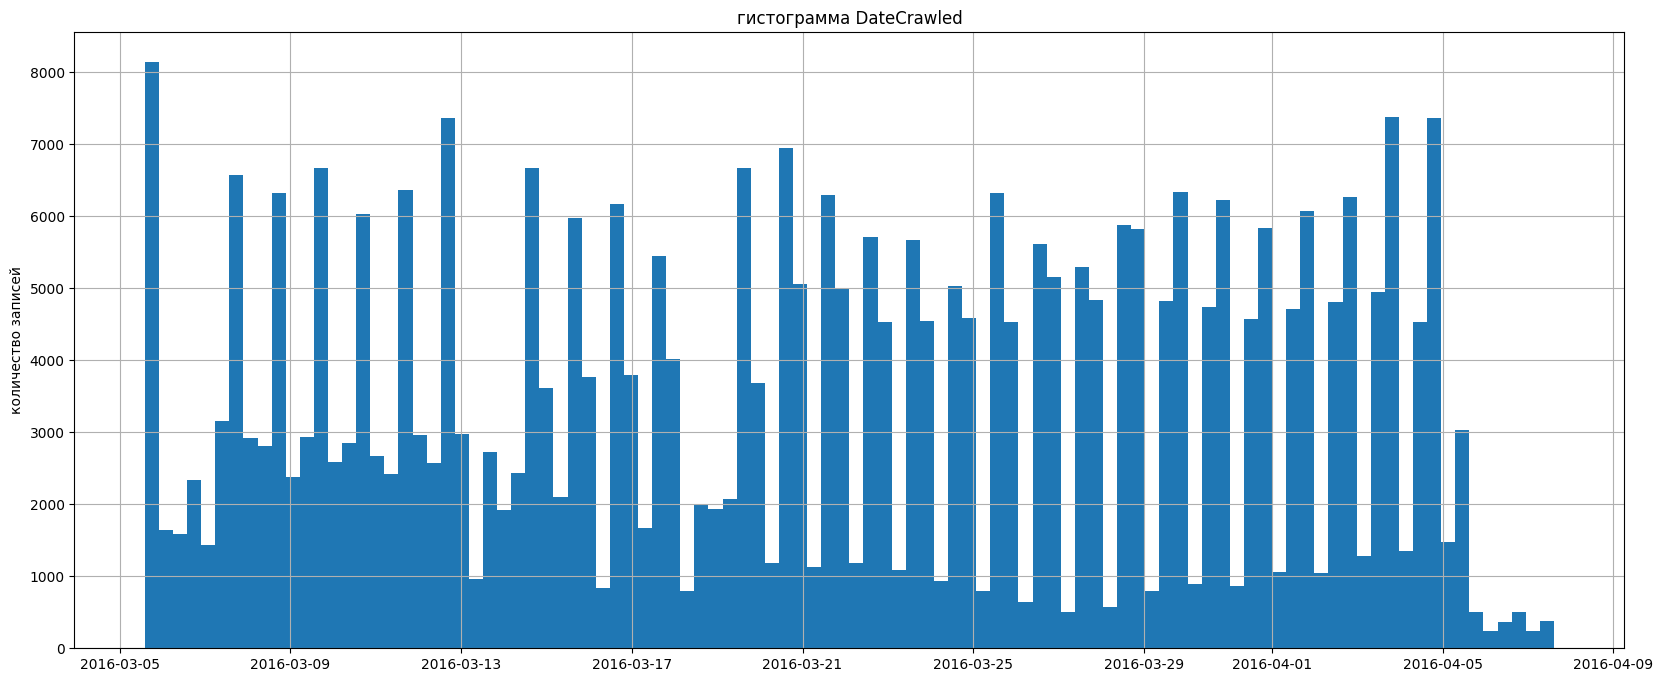

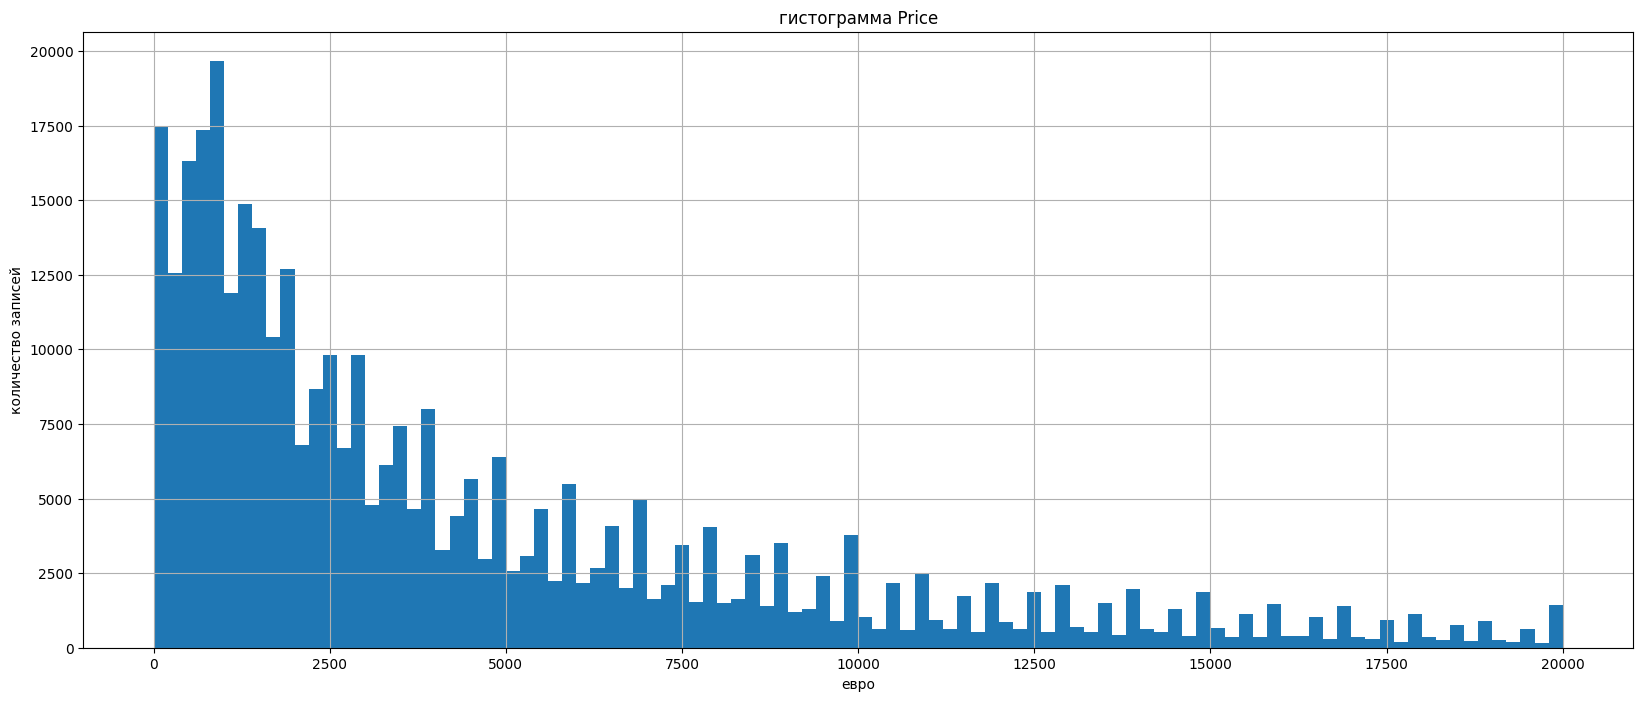

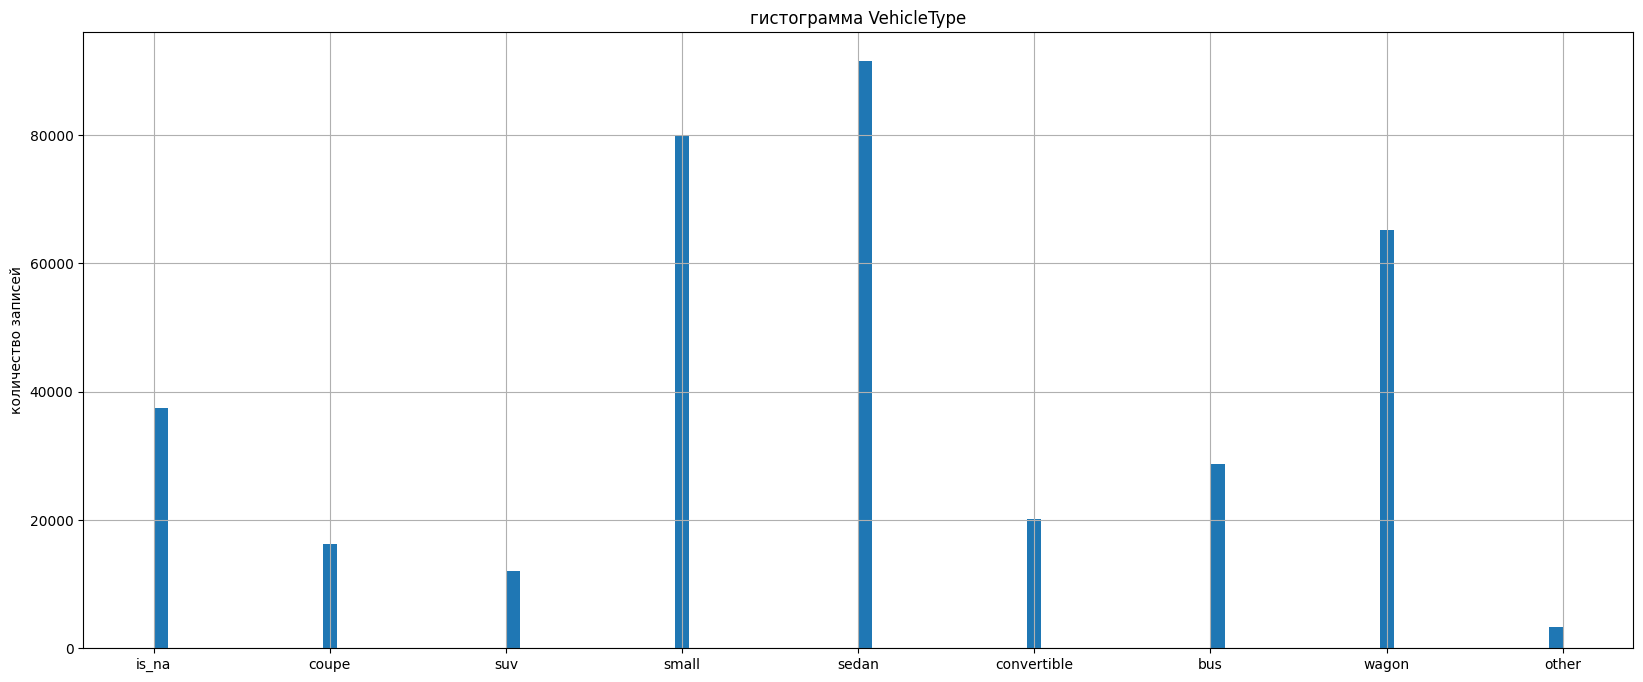

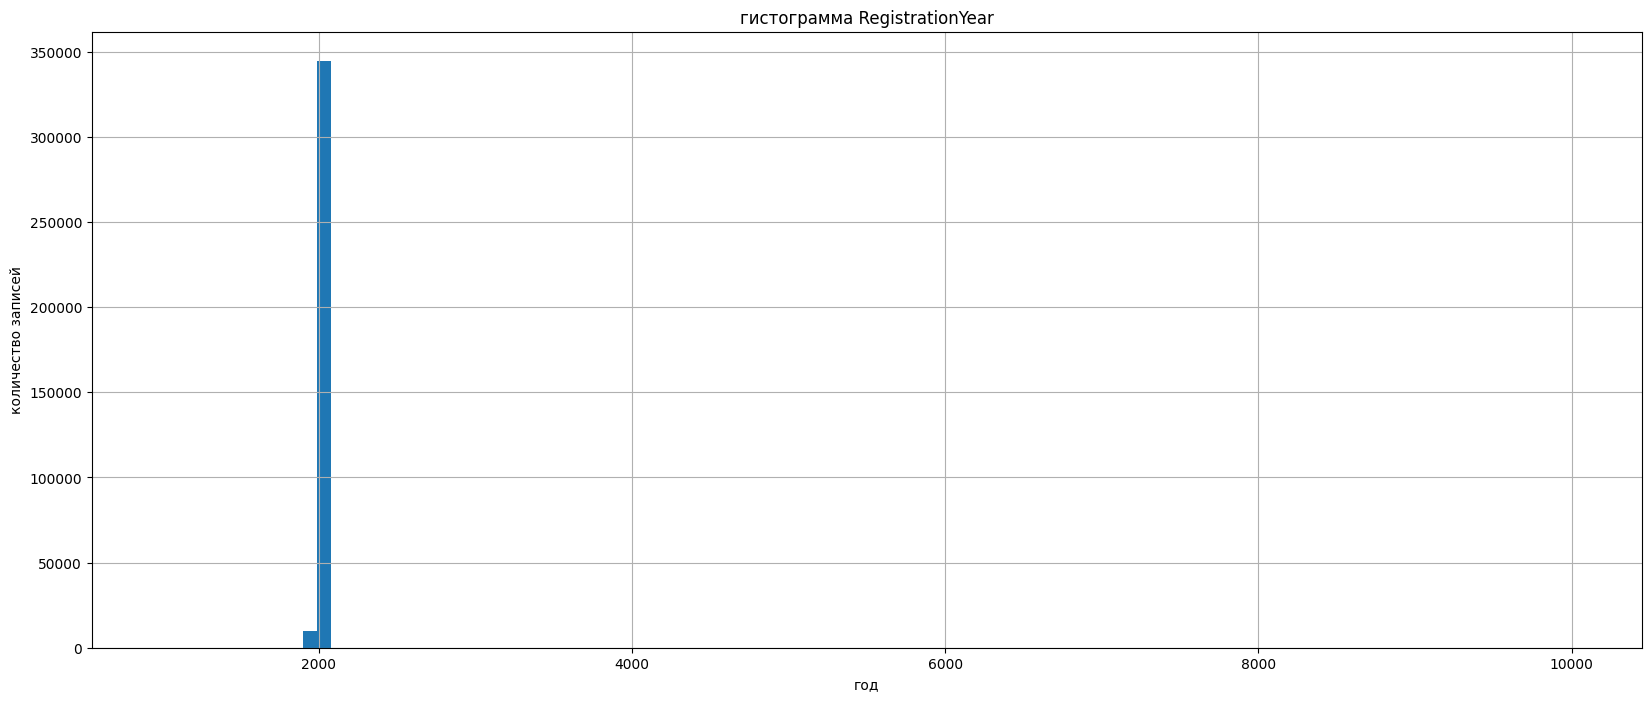

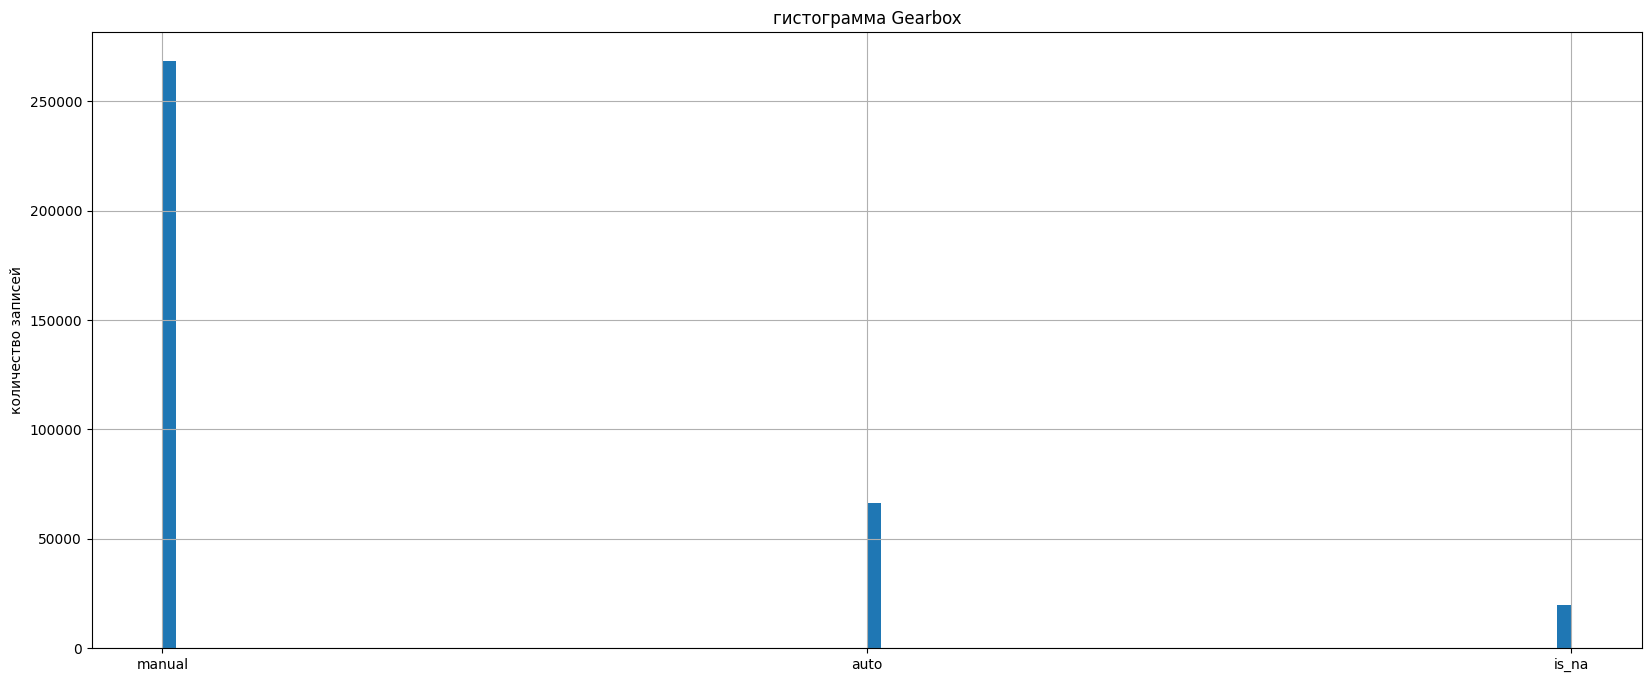

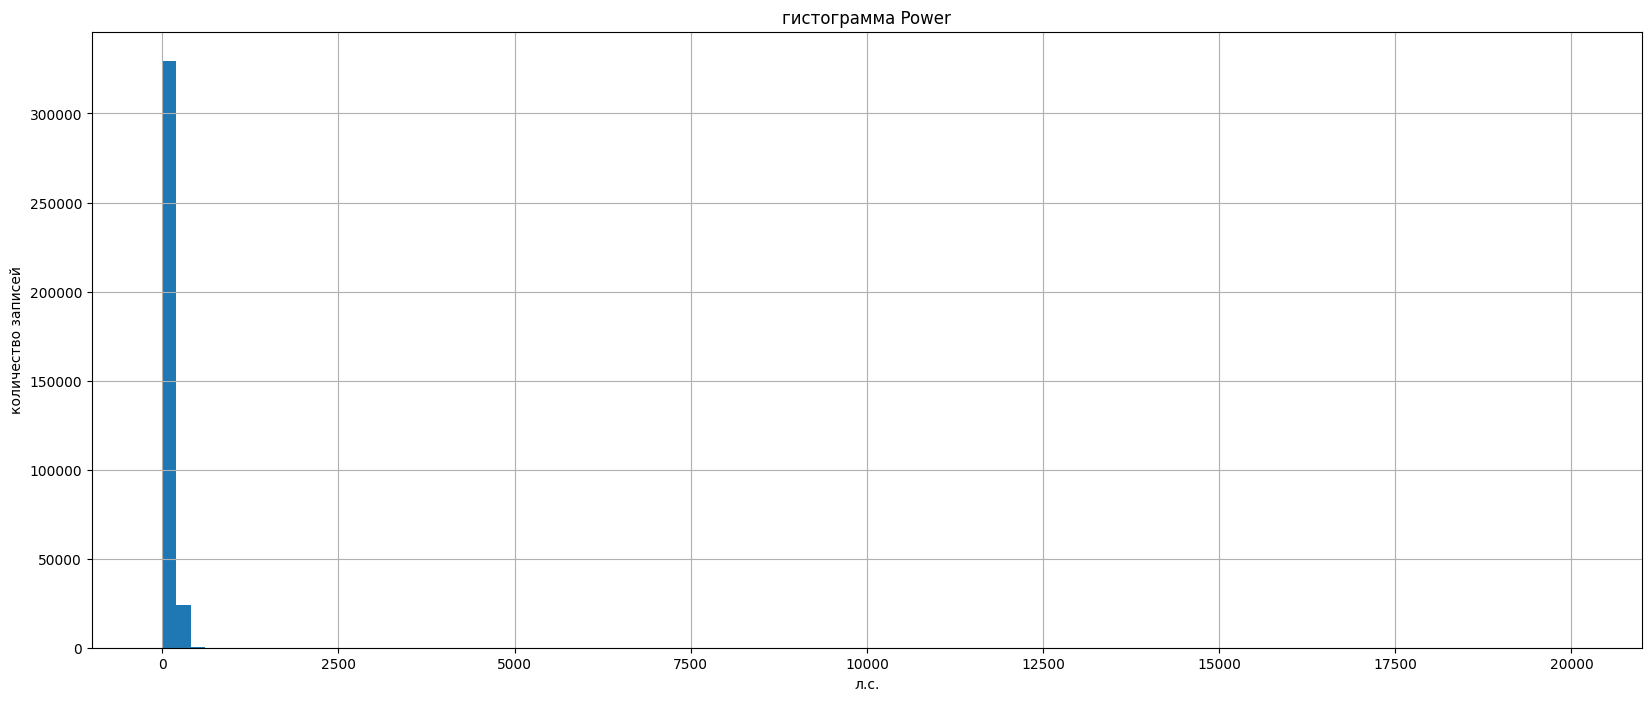

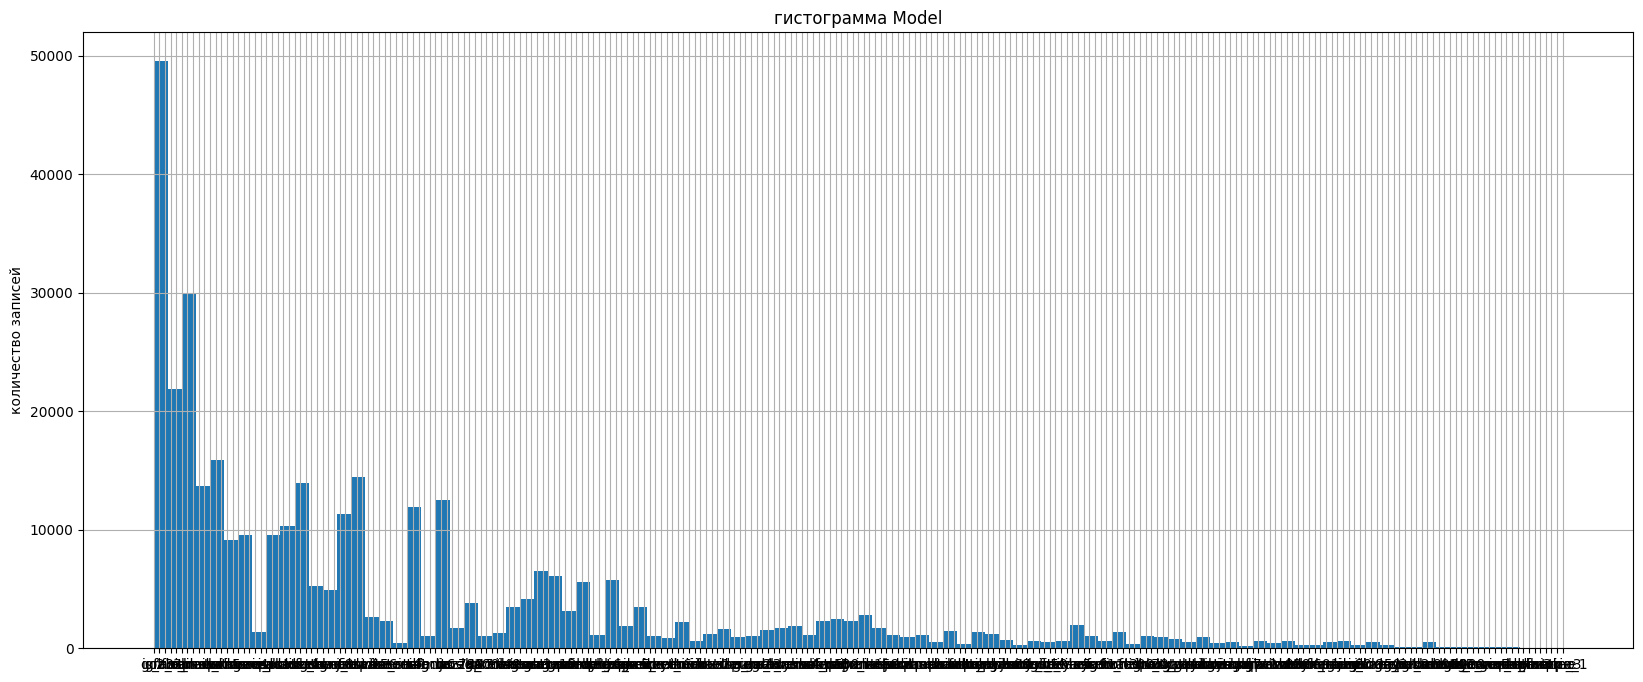

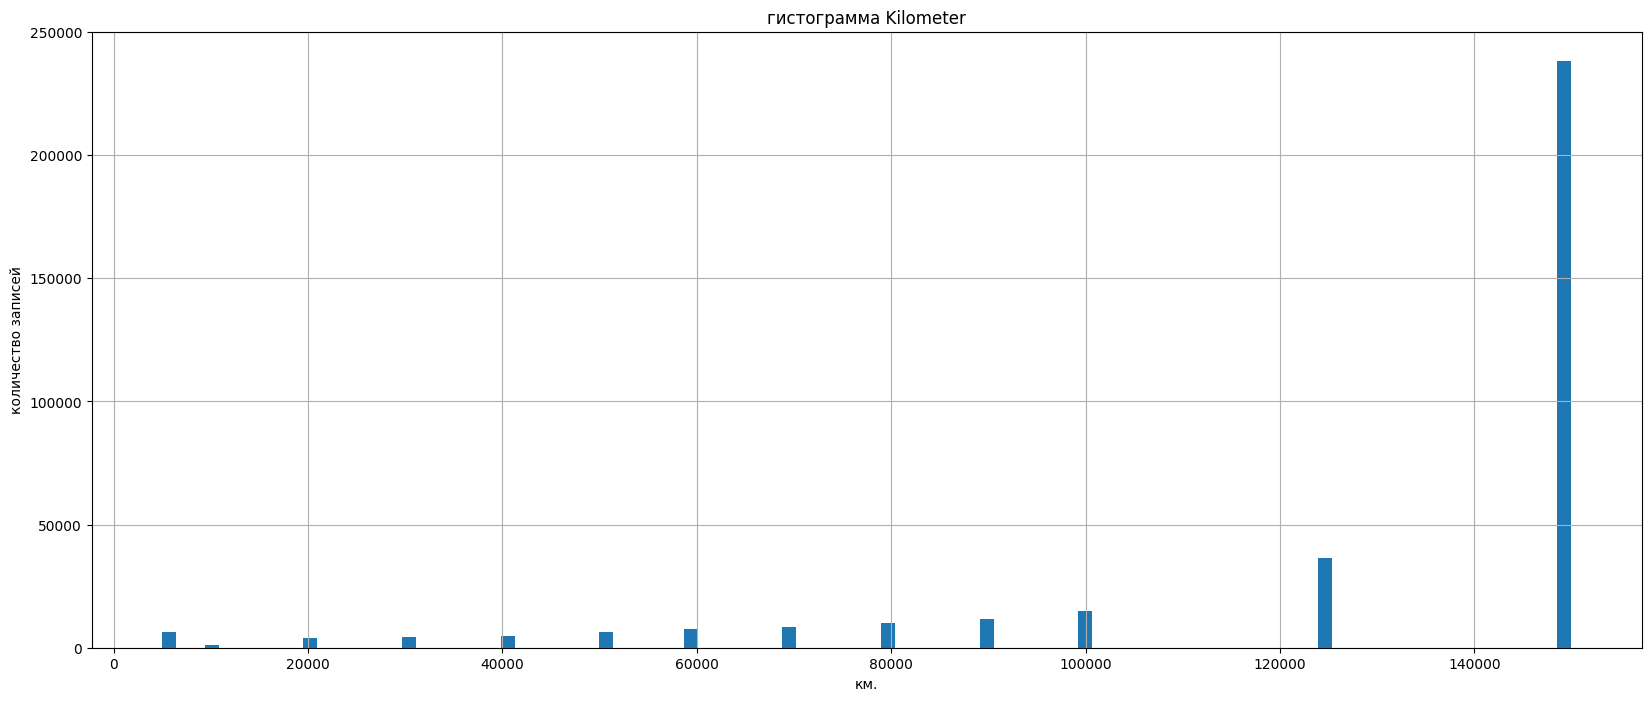

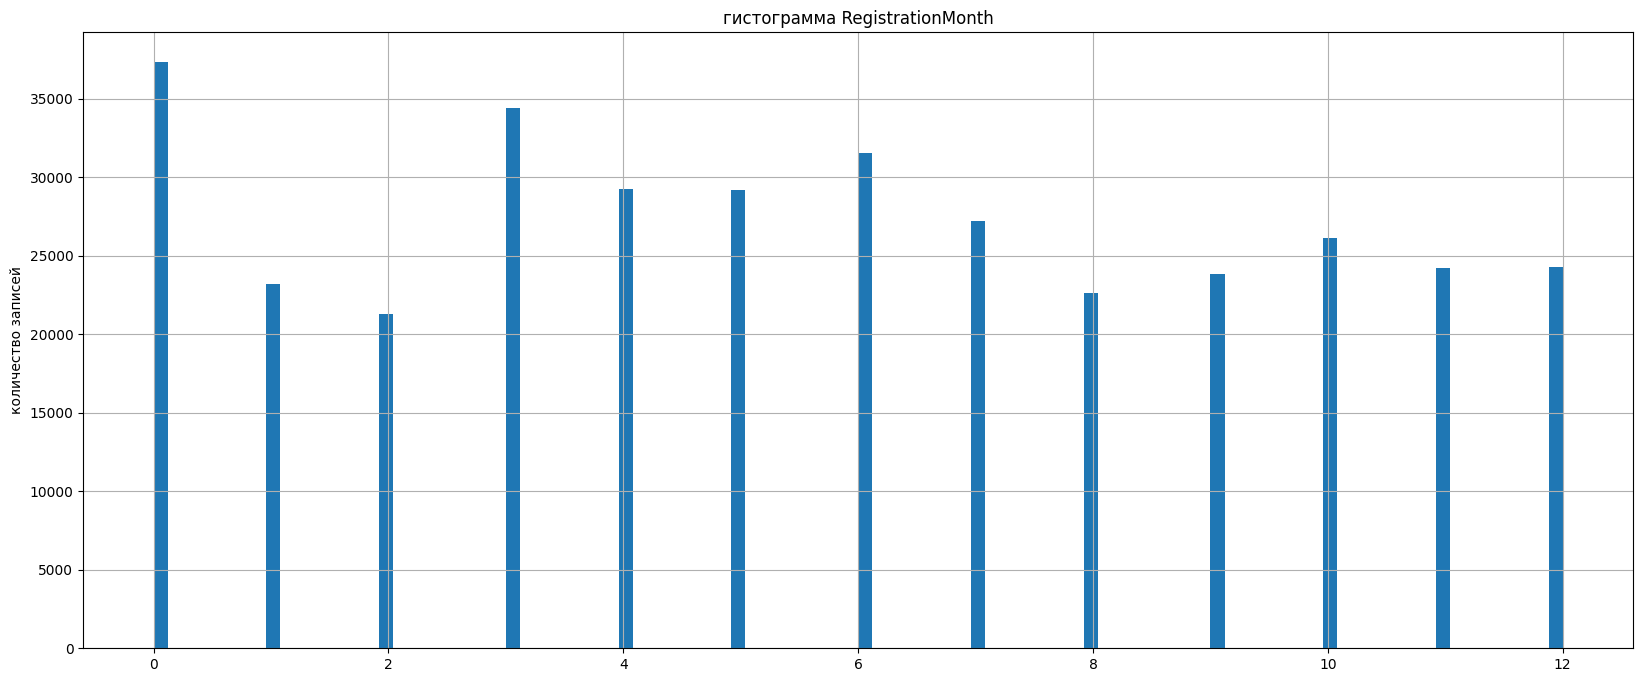

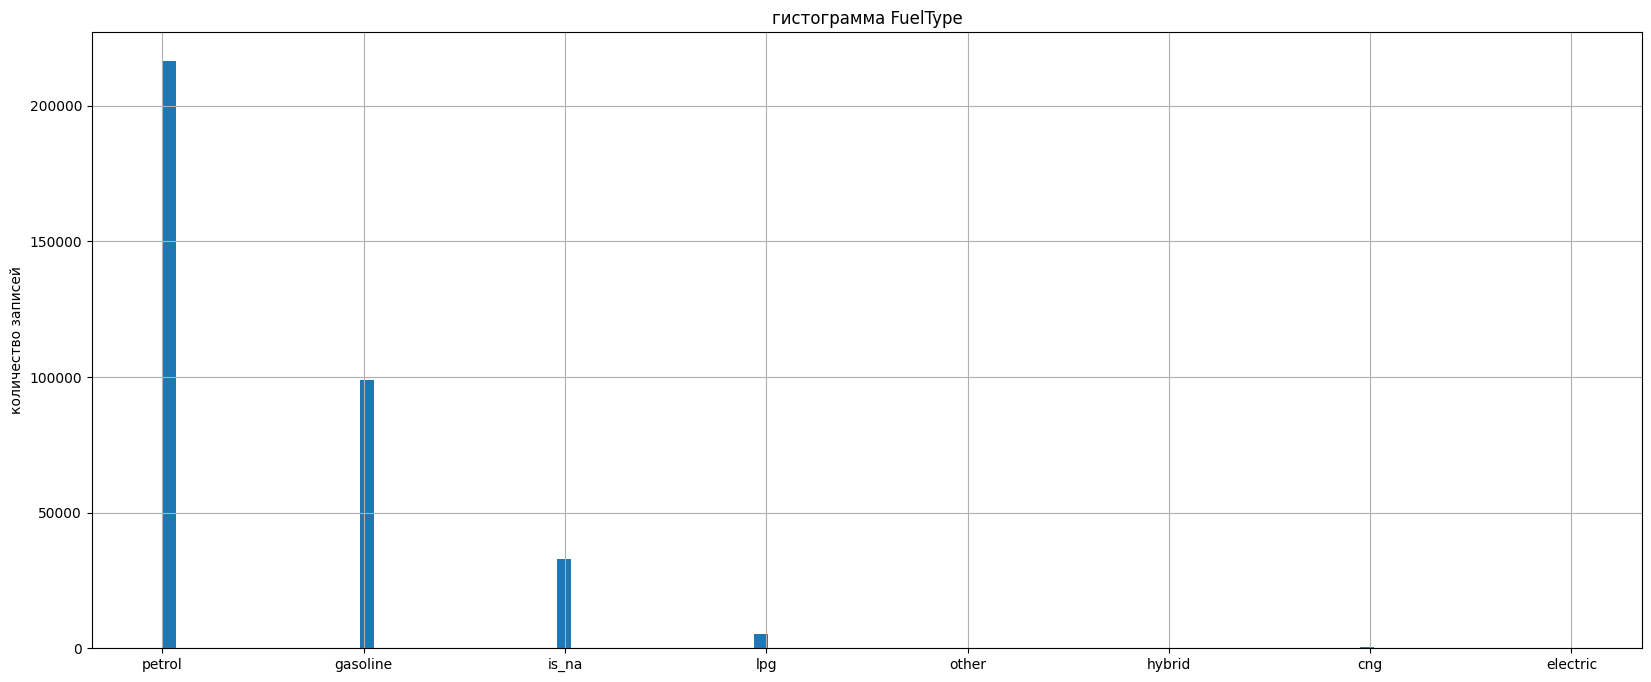

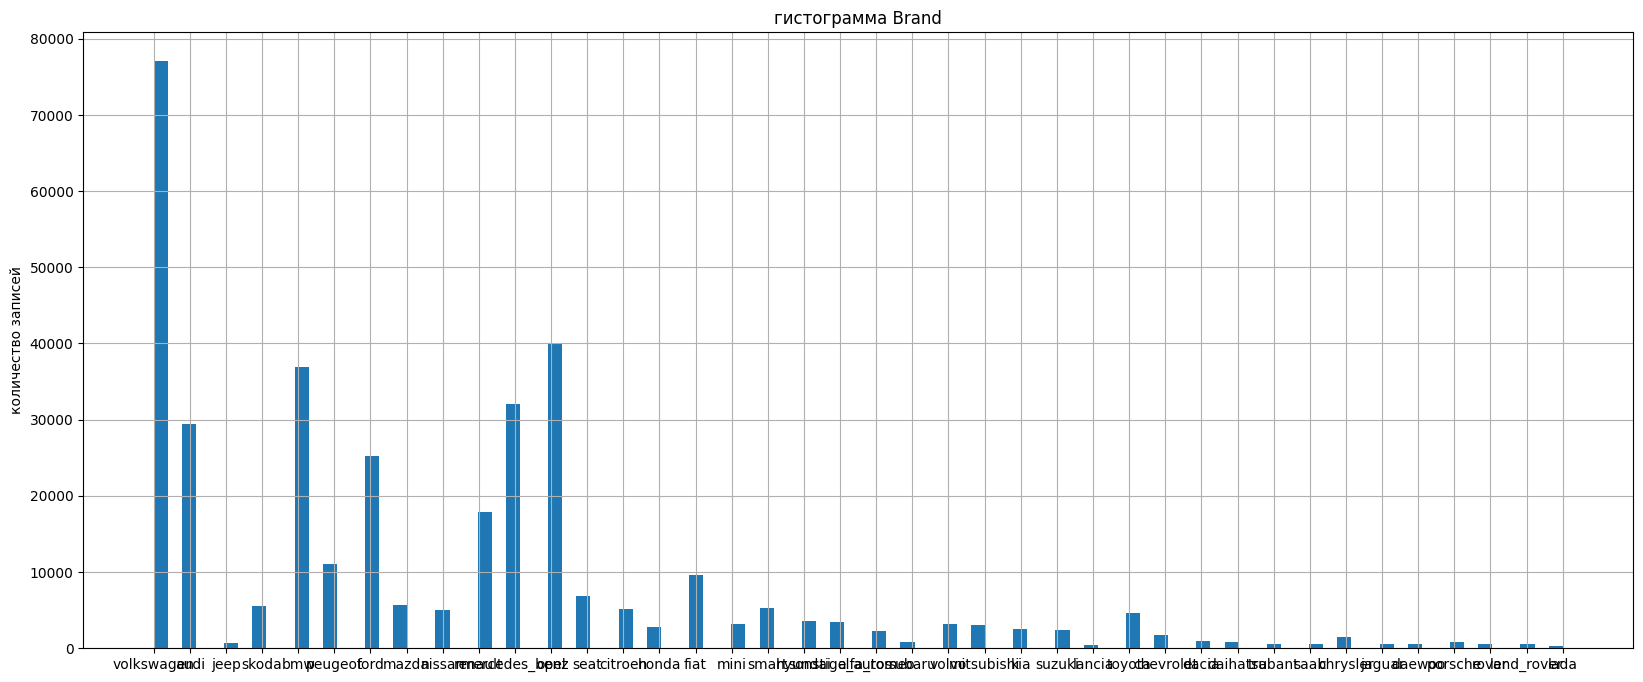

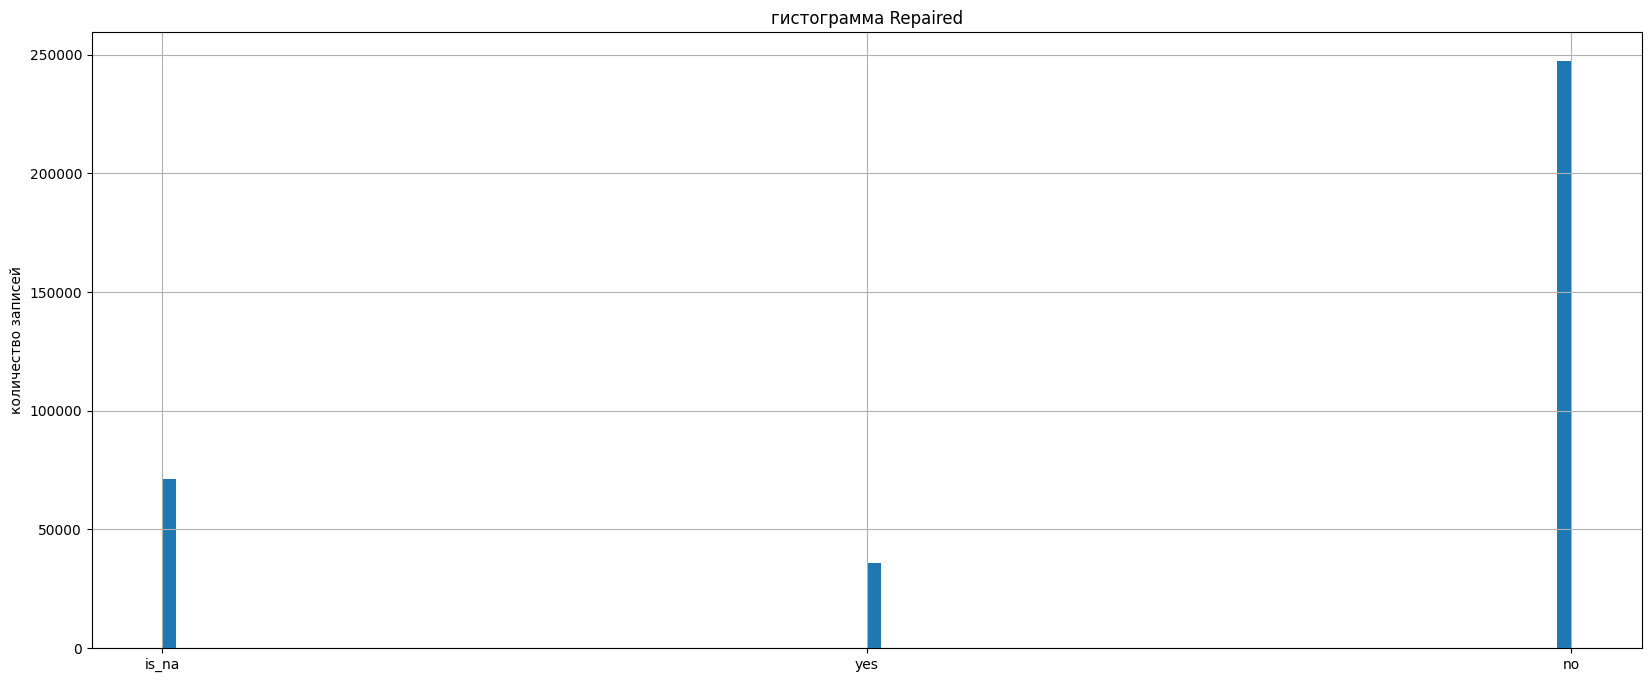

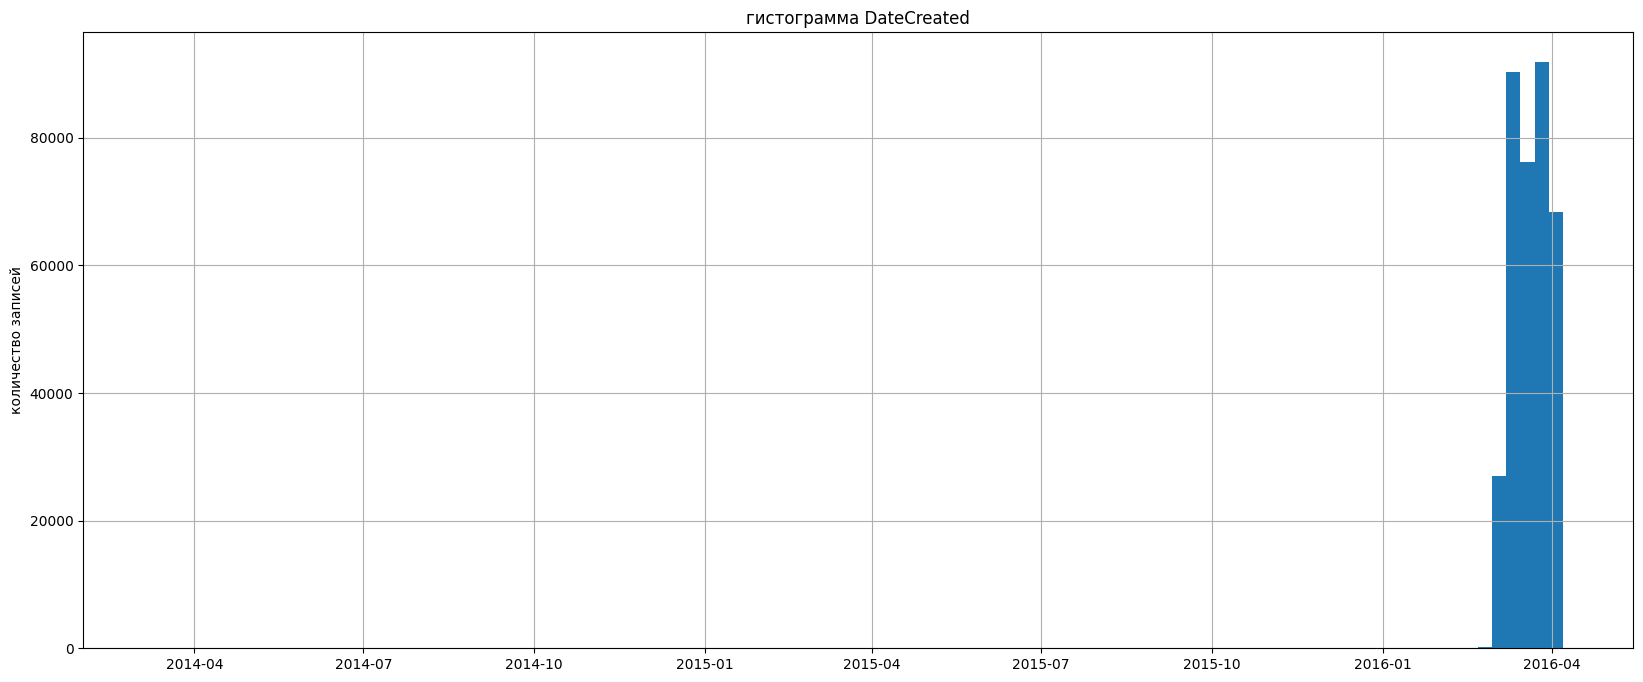

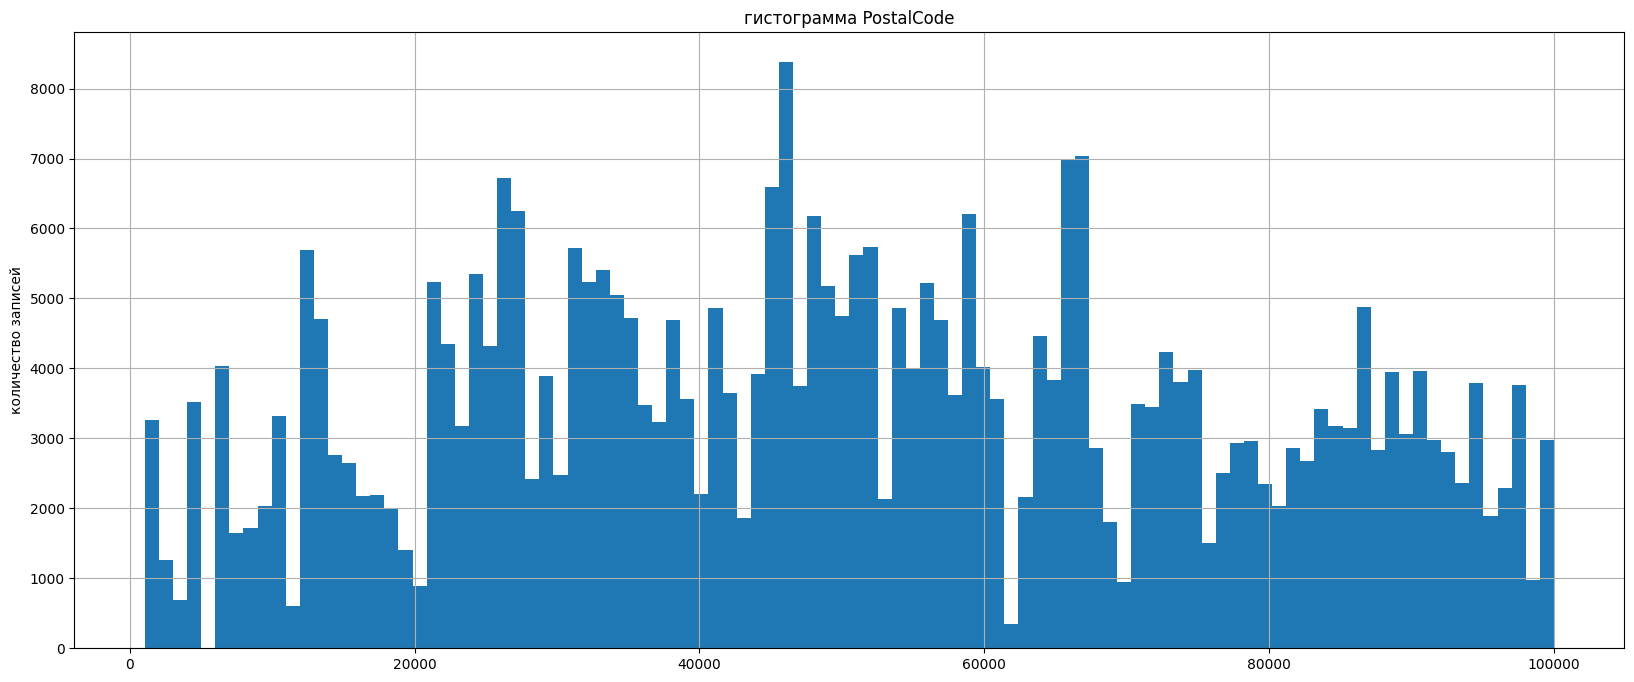

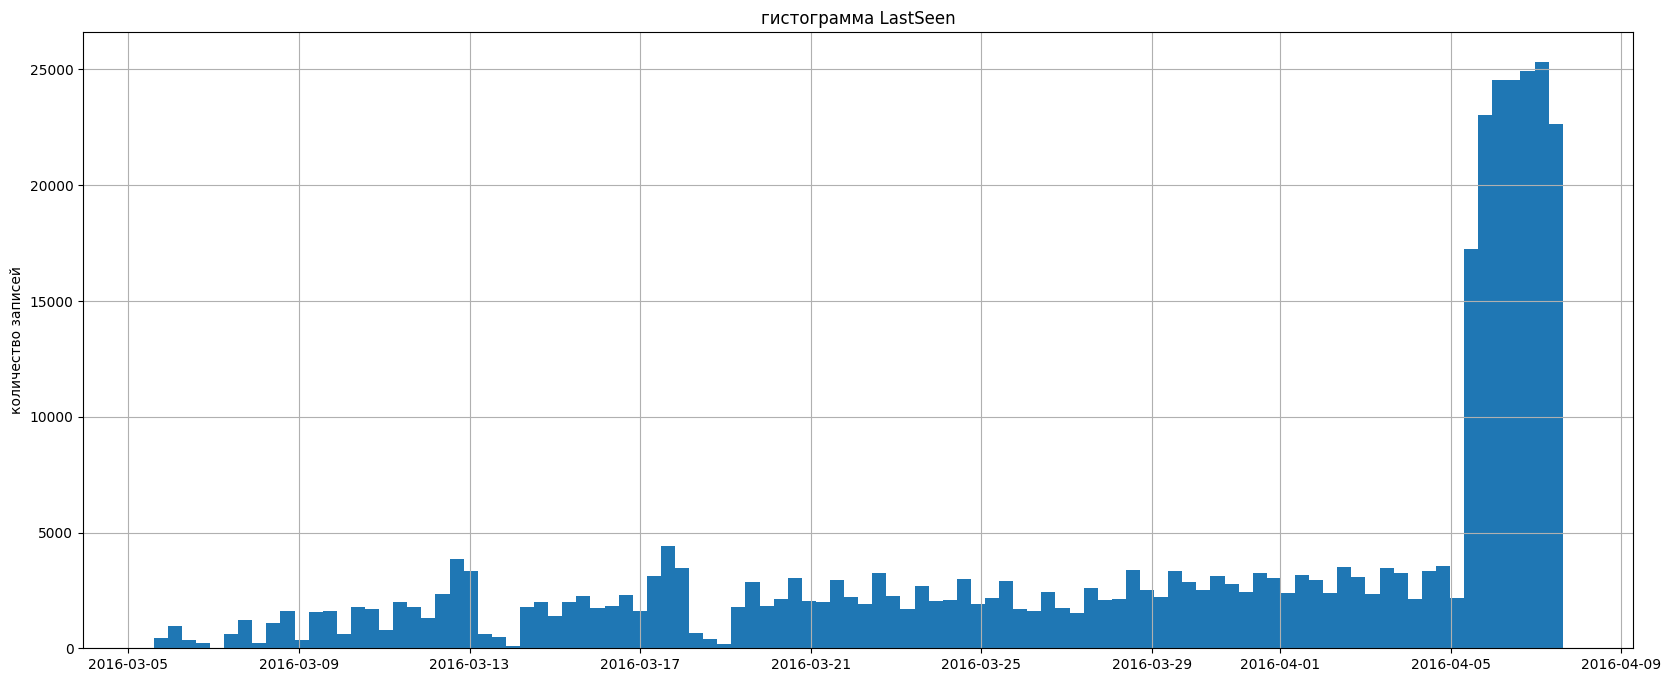

In [12]:
for i in data.columns:
    ax = data[i].hist(figsize=(20,8), bins = 100, label='гистограмма '+str(i))
    ax.set_ylabel("количество записей")
    plt.title('гистограмма '+str(i))
    if i == 'Price': ax.set_xlabel("евро")
    if i == 'RegistrationYear': ax.set_xlabel("год")
    if i == 'Power': ax.set_xlabel("л.с.")
    if i == 'Kilometer': ax.set_xlabel("км.")
        
    plt.show()

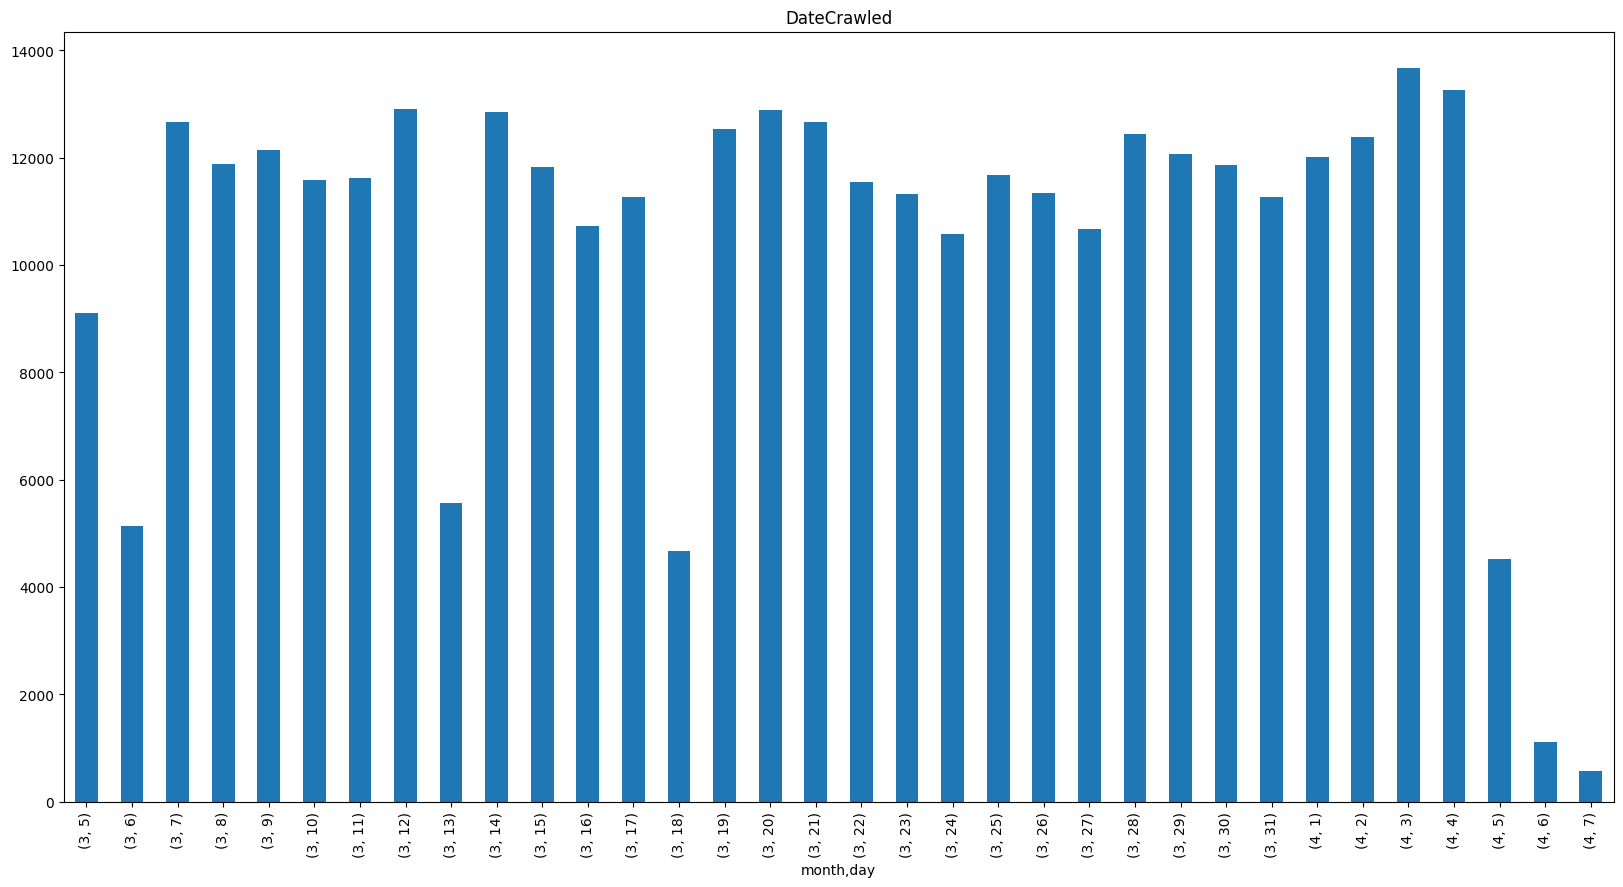

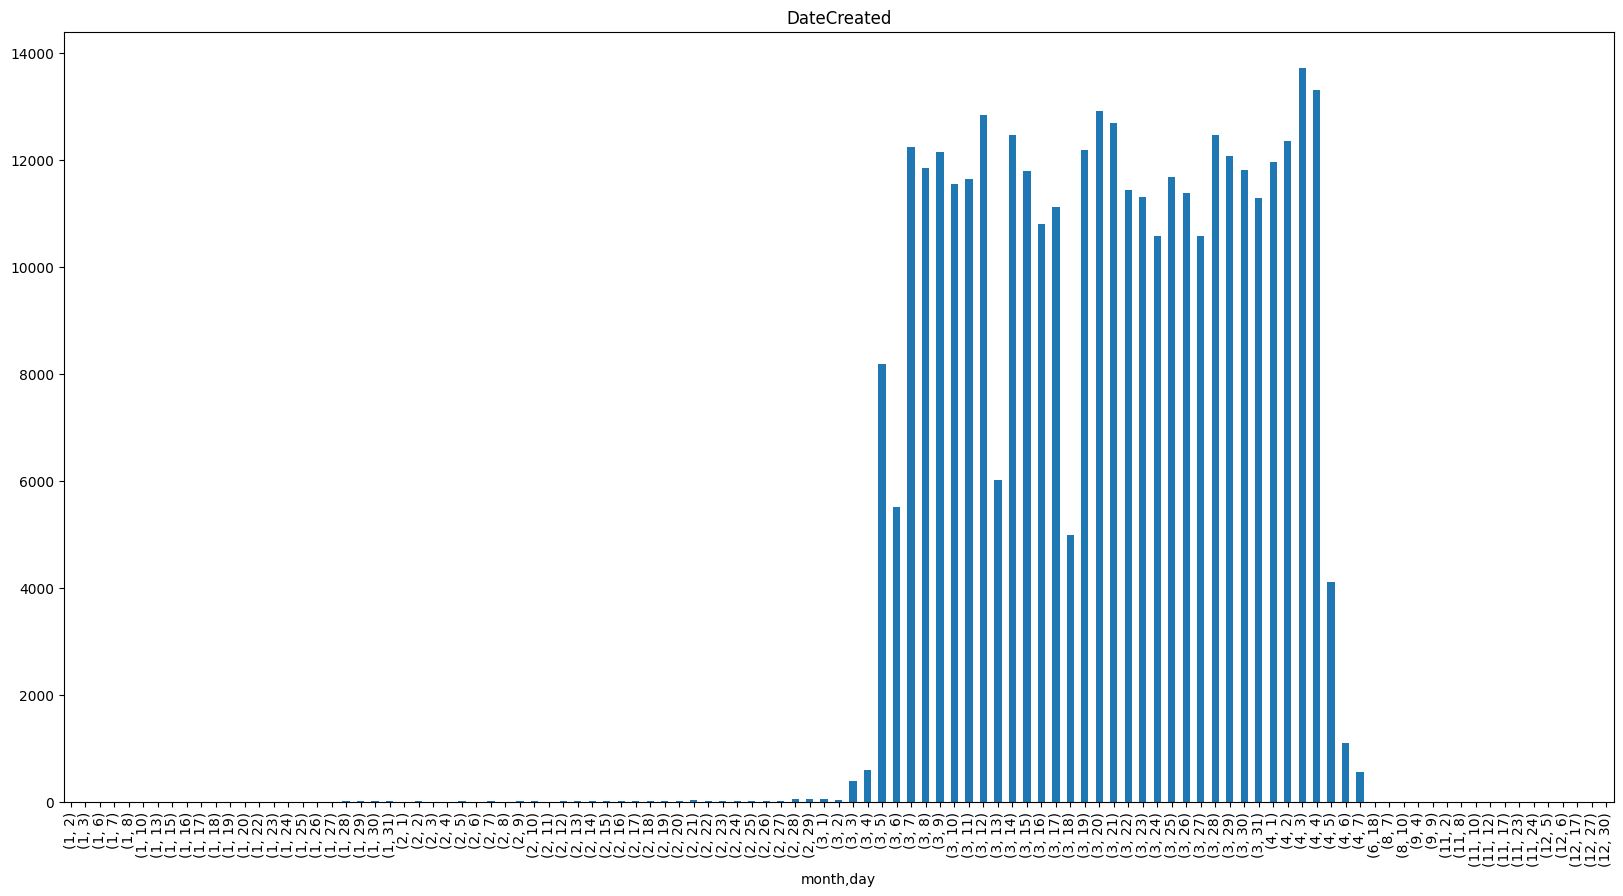

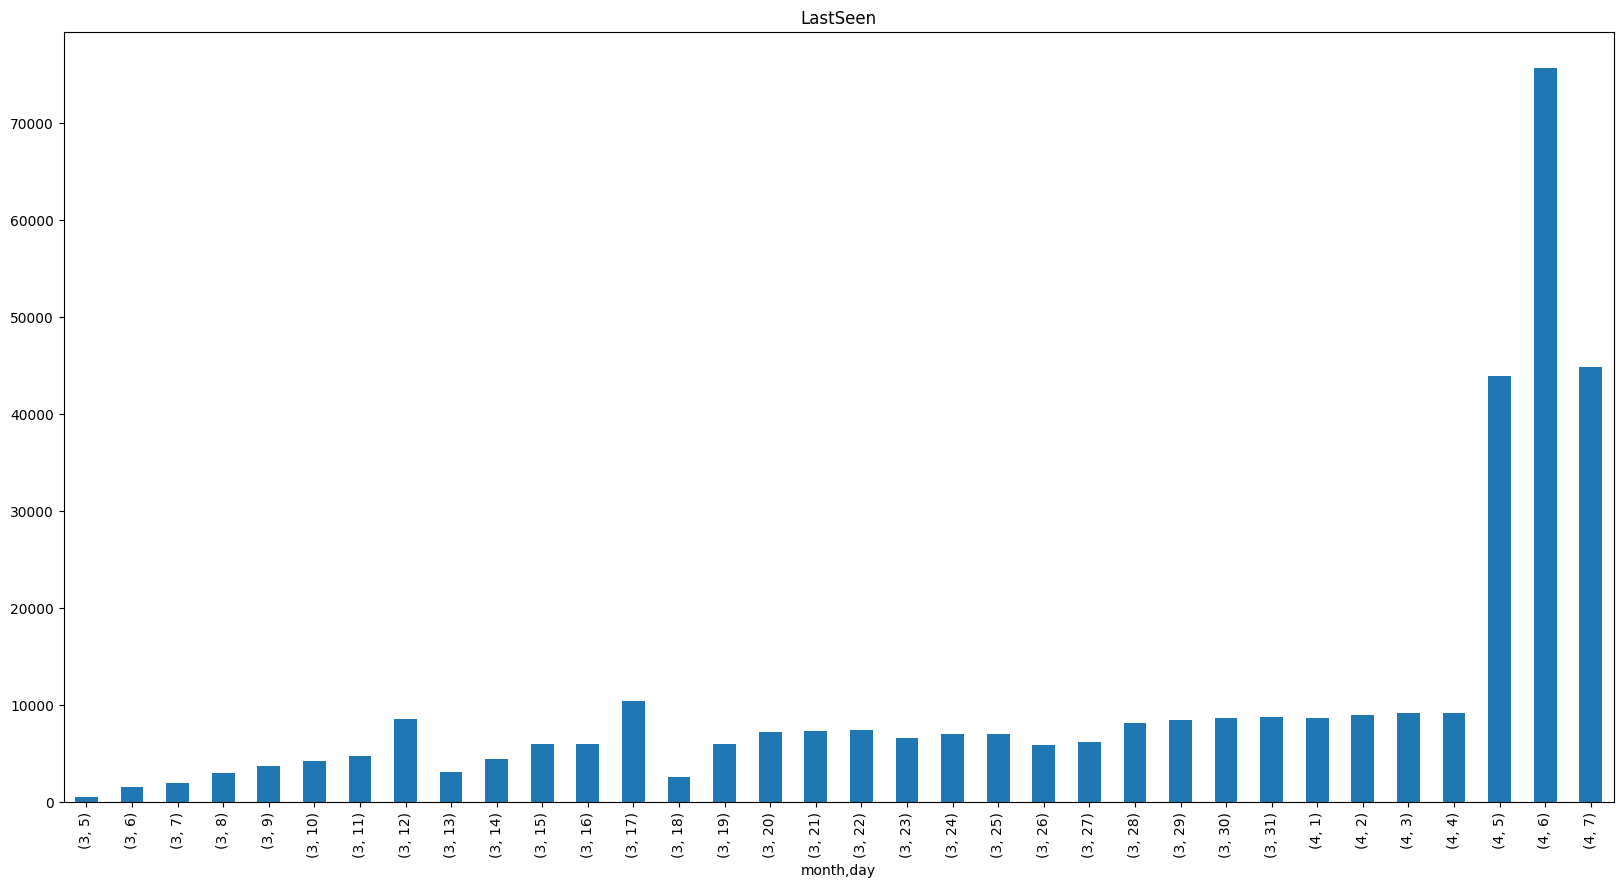

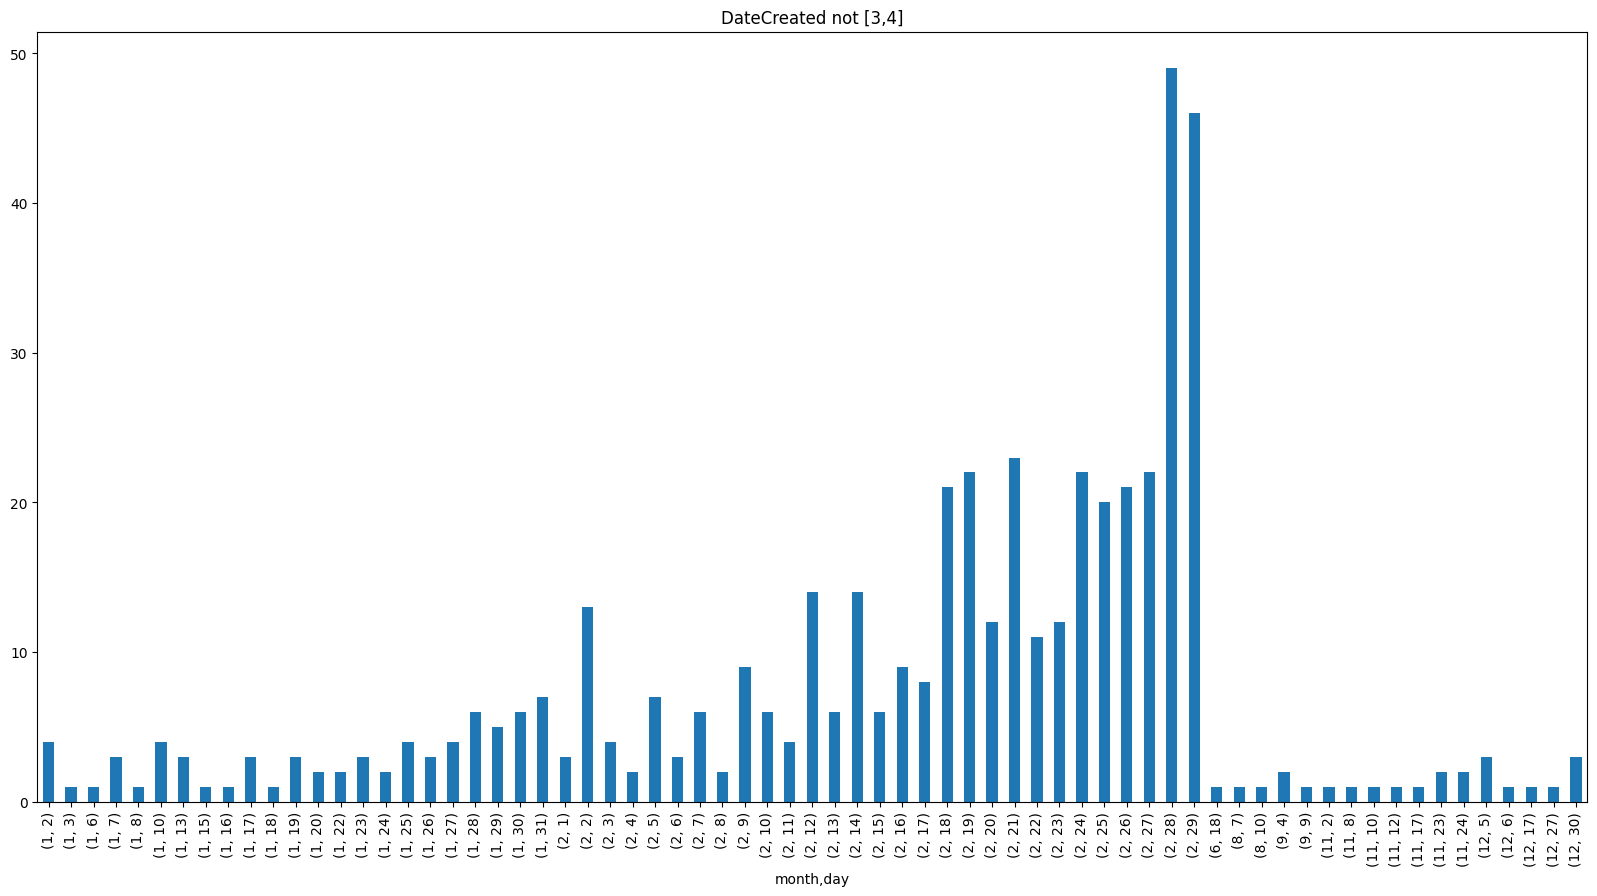

In [13]:
for i in data.columns:
    if type(data[i][0]) == pd._libs.tslibs.timestamps.Timestamp:
        data.groupby([data[i].dt.month, data[i].dt.day]).count()[i].plot(
            kind="bar", title=i,figsize=(20,10), xlabel='month,day')
    plt.show()
data[~(data.DateCreated.dt.month.isin([3,4]))].groupby([data.DateCreated.dt.month, data.DateCreated.dt.day])\
.count().DateCreated.plot(kind="bar", title='DateCreated not [3,4]',figsize=(20,10), xlabel='month,day');
plt.show()

In [14]:
data[['PostalCode', 'Price', 'Repaired']]

,PostalCode,Price,Repaired
0,70435,480,is_na
1,66954,18300,yes
2,90480,9800,is_na
3,91074,1500,no
4,60437,3600,no
...,...,...,...
354360,2694,0,yes
354361,39576,2200,is_na
354362,26135,1199,no
354363,87439,9200,no


In [15]:
# %%time
# tmp = sns.pairplot(data_tmp, kind='kde', hue='Repaired')
# tmp = sns.pairplot(data[['PostalCode', 'Price', 'Repaired']], kind='kde', hue='Repaired')

Для экономии времени заскриншотил вывод:
![image](https://gifara.ru/ds/3a01/pic1.png)
![image](https://gifara.ru/ds/3a01/pic2.png)

Предположительно все четыре столбца (дата скачивания анкеты из базы, дата создания анкеты, дата последней активности пользователя) никак не должны сказываться на цене. Удаляем.


In [16]:
for i in ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode']:
    try: data=data.drop(i, axis=1)
    except: pass
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,is_na,1993,manual,0,golf,150000,0,petrol,volkswagen,is_na
1,18300,coupe,2011,manual,190,is_na,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,is_na
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354360,0,is_na,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354361,2200,is_na,2005,is_na,0,is_na,20000,1,is_na,sonstige_autos,is_na
354362,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Удалим выбросы в столбце `RegistrationYear`

In [17]:
tmp = (data[(data.RegistrationYear > 2017) | (data.RegistrationYear < 1960)].RegistrationYear.count()
       / data.RegistrationYear.count() )
display(f'доля выбросов: {tmp:.1%}')
display(data.shape)
data = data[(data.RegistrationYear <= 2017) & (data.RegistrationYear >= 1960)]
display(data.shape)

'доля выбросов: 1.3%'

(354365, 11)

(349854, 11)

In [18]:
data.RegistrationMonth.value_counts().sort_index()

RegistrationMonth
0     36216
1     22915
2     21027
3     33976
4     28919
5     28852
6     31182
7     26951
8     22398
9     23595
10    25869
11    23937
12    24017
Name: count, dtype: int64

13 месяцев... Без возможности определить где некорректные данные... Оставляем как есть.

In [19]:
data = data.drop('RegistrationMonth', axis=1)

Посмотрим выбросы в поле `Price`

In [20]:
#tmp = data[data.Price < 2].Price.count()/data.Price.count() #v1
tmp = data[data.Price < 1000].Price.count()/data.Price.count() #v2

display(f'Доля бесплатных машин: {tmp:.1%}')
#data = data[data.Price >= 2] #v1
data = data[data.Price >= 1000] #v2

'Доля бесплатных машин: 23.5%'

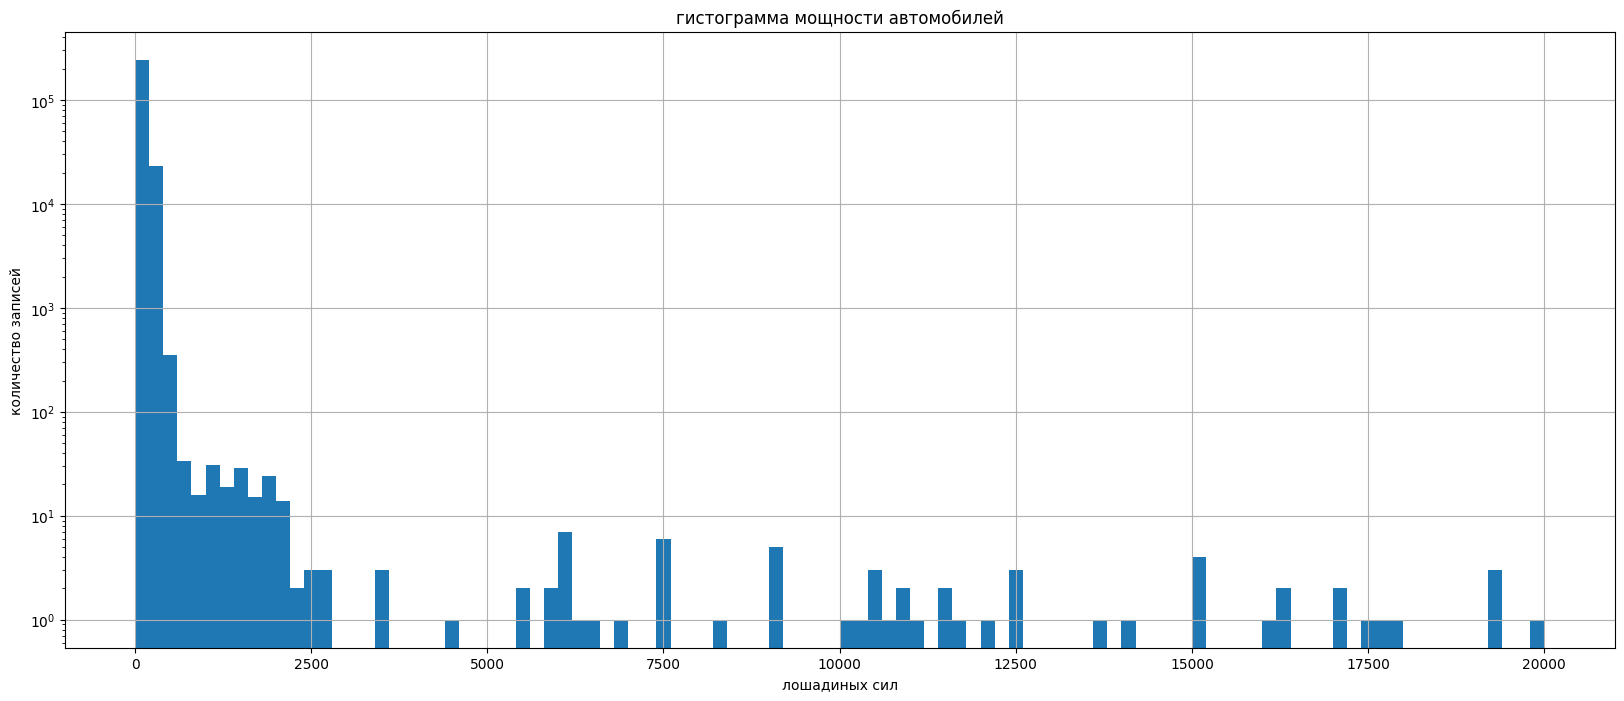

In [21]:
ax = data.Power.hist(figsize=(20,8), log=True, bins = 100)
ax.set_ylabel("количество записей")
ax.set_xlabel("лошадиных сил")
plt.title('гистограмма мощности автомобилей')
plt.show()

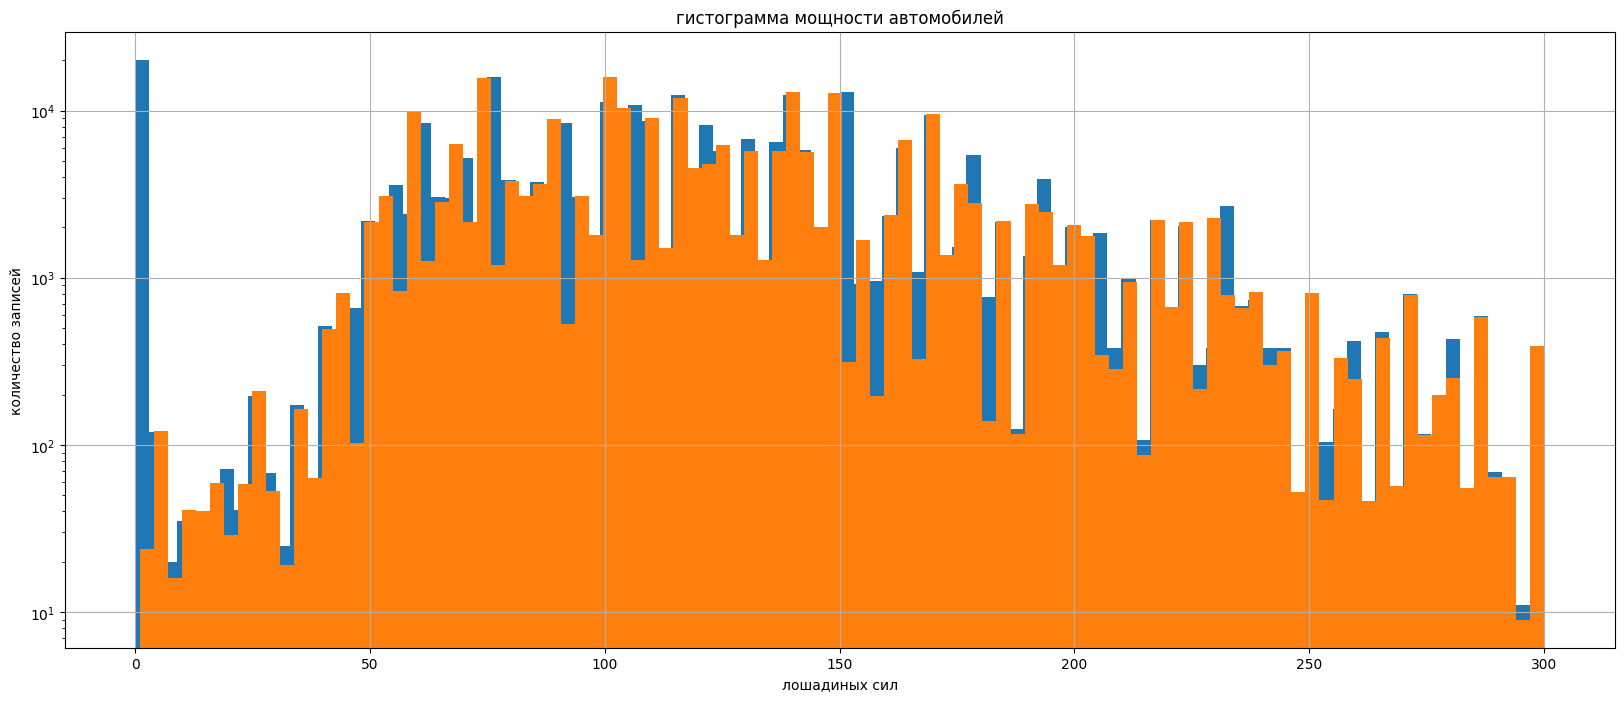

In [22]:
#v3
ax = data.Power.hist(figsize=(20,8), log=True, bins = 100, range=(0, 300))
ax.set_ylabel("количество записей")
ax.set_xlabel("лошадиных сил")
plt.title('гистограмма мощности автомобилей')
data.Power.hist(figsize=(20,8), log=True, bins = 100, range=(1, 300))
plt.show()

In [23]:
data = data[(data.Power < 2500) & (data.Power >= 1)] #v3 интернет говорит, что минимальная мощность 0.75 л.с.

In [24]:
train, valid = train_test_split(data, test_size=0.20, random_state=RS)

In [25]:
pipe_num = Pipeline(steps=[('scaler', StandardScaler())])
pipe_cat = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))]) #v2


In [26]:
col_transformer = ColumnTransformer(transformers=[
    ('num_preproc', pipe_num, [x for x in data.columns if (data[x].dtype != 'object') &
        (x not in ['Price', 'Kilometer'])]),
    ('cat_periodic', pipe_cat, [x for x in data.columns if (data[x].dtype == 'object') | (x == 'Kilometer')])])

## Обучение моделей

<div class=style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px; background: #ddd">

* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
* Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
</div>

Действия однотипны, подготовим инструменты:

In [27]:
result = pd.DataFrame(columns=['label', 'best_param', 'time_fit', 'time_predict', 'rmse', 'best_model']) #v3
RMSE=lambda x,y: MSE(x, y)#, squared=False)
#from sklearn.metrics import root_mean_squared_error
#RMSE=lambda x,y: root_mean_squared_error(x, y)
score_RMSE = make_scorer(RMSE, greater_is_better=False)

In [28]:
def get_metrics(*, param_grid, model, label, train, to_predict):
    if model != DummyRegressor:
        pipeline_current = Pipeline(steps = [('preprocessor', col_transformer),
                                         ('regressor', model(random_state=RS) )])
    else:
        pipeline_current = Pipeline(steps = [('preprocessor', col_transformer),
                                         ('regressor', model() )])
    model_current = GridSearchCV(pipeline_current, verbose=VERBOSE, param_grid=param_grid, cv=CV,
        refit=True, error_score = 'raise', scoring=score_RMSE)    
    model_current.fit(train.drop('Price', axis=1), train.Price)
    time_fit = model_current.refit_time_
    exist_hyper=[]
    for i in list(model_current.get_params().keys()):
        if 'estimator__regressor__' in i: exist_hyper.append(i.replace('estimator__regressor__', ''))
    display(f"доступные гиперпараметры: {exist_hyper}")
    display(f'Лучшие гиперпараметры: {model_current.best_params_}')
    start=time.time()
    tmp = model_current.best_estimator_.predict(train.drop('Price', axis=1))
    time_predict = time.time() - start
    return pd.Series({'label':label, 'best_param': model_current.best_params_, 'time_fit': time_fit,
        'time_predict': time_predict,
        'rmse': - model_current.best_score_,
        'best_model': model_current.best_estimator_})

In [29]:
# подавление предупреждений о том,что в одном из столбцов одни нули (результат handle_unknown='ignore')
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

Используем модель леса:

In [30]:
result.loc[len(result)] = get_metrics(model=DecisionTreeRegressor,
            param_grid={
                'regressor__max_depth': list(range(13,15)), # проверен в v1 list(range(7,15))
                'regressor__min_samples_leaf': list(range(9, 11))}, # проверен в v1 list(range(8, 15))
            label='tree', train=train, to_predict=valid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END regressor__max_depth=13, regressor__min_samples_leaf=9;, score=-1965.110 total time=   9.2s
[CV 2/3] END regressor__max_depth=13, regressor__min_samples_leaf=9;, score=-1969.118 total time=   9.1s
[CV 3/3] END regressor__max_depth=13, regressor__min_samples_leaf=9;, score=-1972.657 total time=   9.0s
[CV 1/3] END regressor__max_depth=13, regressor__min_samples_leaf=10;, score=-1964.051 total time=   9.5s
[CV 2/3] END regressor__max_depth=13, regressor__min_samples_leaf=10;, score=-1975.428 total time=   9.1s
[CV 3/3] END regressor__max_depth=13, regressor__min_samples_leaf=10;, score=-1972.228 total time=   8.9s
[CV 1/3] END regressor__max_depth=14, regressor__min_samples_leaf=9;, score=-1936.289 total time=   9.7s
[CV 2/3] END regressor__max_depth=14, regressor__min_samples_leaf=9;, score=-1942.049 total time=   9.6s
[CV 3/3] END regressor__max_depth=14, regressor__min_samples_leaf=9;, score=-1941.741 total time=

"доступные гиперпараметры: ['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter']"

"Лучшие гиперпараметры: {'regressor__max_depth': 14, 'regressor__min_samples_leaf': 9}"

Используем модель градиентного бустинга:

In [31]:
result.loc[len(result)] = get_metrics(model=LGBMRegressor,
            param_grid={
                'regressor__max_depth': list(range(13,15)), # проверен в v1 list(range(7,15))
                'regressor__num_leaves': [31, 50]}, # проверен в v1 [28, 31, 50]
            label='LGBMRegressor', train=train, to_predict=valid)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 131876, number of used features: 292
[LightGBM] [Info] Start training from score 5780.725090
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END regressor__max_depth=13, regressor__num_leaves=31;, score=-1772.909 total time=   2.6s
[LightGBM] [Warning] Accuracy may be bad

"доступные гиперпараметры: ['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'subsample', 'subsample_for_bin', 'subsample_freq']"

"Лучшие гиперпараметры: {'regressor__max_depth': 14, 'regressor__num_leaves': 50}"

In [32]:
result.loc[len(result)] = get_metrics(model=DummyRegressor,
            param_grid={},
            label='DummyRegressor', train=train, to_predict=valid)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..............................., score=-4588.641 total time=   1.1s
[CV 2/3] END ..............................., score=-4558.772 total time=   1.1s
[CV 3/3] END ..............................., score=-4579.835 total time=   1.1s


"доступные гиперпараметры: ['constant', 'quantile', 'strategy']"

'Лучшие гиперпараметры: {}'

In [33]:
result.sort_values('rmse')

,label,best_param,time_fit,time_predict,rmse,best_model
1,LGBMRegressor,"{'regressor__max_depth': 14, 'regressor__num_l...",2.668424,1.892477,1744.586885,(ColumnTransformer(transformers=[('num_preproc...
0,tree,"{'regressor__max_depth': 14, 'regressor__min_s...",15.37839,1.301602,1940.026208,(ColumnTransformer(transformers=[('num_preproc...
2,DummyRegressor,{},1.06888,1.107806,4575.749216,(ColumnTransformer(transformers=[('num_preproc...


## Анализ моделей

Для веба LGBMRegressor тяжеловат, но дает более точные предсказания. На стоечном сервере его можно использовать, для "пользовательского" оборудования лучше использовать модель дерева. Она в данном случае выбирается лучшей.

In [34]:
%%time
predict_valid = result[result.label == 'tree'].iloc[0].best_model.predict(valid.drop('Price', axis=1))
RMSE(predict_valid, valid.Price)

CPU times: user 194 ms, sys: 133 ms, total: 327 ms
Wall time: 342 ms


1920.4430272542977

## Выводы
* На стадии подготовки данных:
    * Были выявлены и удалены явные дубликаты
    * Пропуски были заполнены заглушкой
    * Были удалены столбцы, не влияющие на цену автомобиля
    * Были удалены выбросы в столбцах `RegistrationYear` и `Price`
* На стадии обучения моделей:
    * Были использованы модели `DecisionTreeRegressor` и `LGBMRegressor`
    * Для моделей производился выбор лучших гиперпараметров
    * На основе выбранных гиперпараметров были обучены модели, и сняты необходимые метрики
* На стадии анализа моделей:
    * Порог RMSE был успешно преоболен обоими моделями.
    * Лучшей была признана модель дерева, которая быстро работает и дает предсказания с приемлемой погрешностью.
